This notebook is a modified version of one provided in the [GitHub Repository](https://github.com/JiamingZhuge/FRB_ML_unsp/tree/main) of Zhu-Ge et al. 2023 - [Machine learning classification of CHIME fast radio bursts: II. Unsupervised Methods](https://arxiv.org/abs/2210.02471).

Minor changes have been made to the physical feature calculations to allow it to work.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv(f"./data/raw_data/combined_2021_23_catalog.csv")
pd.set_option("display.max_columns", None)

# Physical Feature extraction

## Redshifts


$\Omega_b(baryon),\Omega_{c}(cold\;dark\;matter),\Omega_r(radiation\;energy)$


In [2]:
import astropy.units as units
import numpy as np

# Parameters
H = 67.4  # 67.3 #km/s/Mpc
h = H / 100
h2 = h * h
O_b = 0.0224 / h2  # 0.0486
O_m = 0.315  # matter
O_k = 0
O_L = 1 - O_m - O_k  # dark energy

c = 299792458  # m/s
pc_m = 3.085677581491367e16
cm = 100
km = 1000
M = 1e6
m_p = 1.67262192e-27  # kg
G = 6.67430e-11  # m^3/kg/s^2

$ \Omega_b\frac{3H_0 c}{8\pi G m_p}\frac{7}{8} $


In [3]:
alpha = (
    3 * 7 * H * c * O_b / 8 / 8 / np.pi / G / m_p * km / M / pc_m / cm / cm / cm / pc_m
)

In [4]:
from scipy import integrate


def f_IGM(z):
    return 0.83  # (z>1.5)*0.9+(z<=1.5)*(0.053*z+0.82)


def I_IGM(z, m=O_m, la=O_L):
    return (1.0 + z) * f_IGM(z) / np.sqrt(m * (1.0 + z) ** 3 + la)


def f_DM(z, a=alpha):
    Int = integrate.quad(I_IGM, 0, z)[0]
    return 30.0 + a * Int + 70.0 / (1.0 + z)

$DM-DM_{MW}=30+DM_{IGM}+\frac{70}{1+z}$


In [5]:
from scipy.optimize import fsolve


def f_z(DM_MW, n=8):
    return fsolve(lambda z: f_DM(z) - DM_MW, 0)[0]

In [6]:
z_min = H * 10 / c * 1000

DM_MWs = df["dm_exc_ne2001"].values
redshift = np.zeros(len(DM_MWs))
for i, DM_MW in enumerate(DM_MWs):
    redshift[i] = f_z(DM_MW)
    if redshift[i] <= z_min:
        # print(i)
        redshift[i] = z_min
df["redshift"] = redshift

In [7]:
known_redshifts = {
    "FRB20121102A": 0.19273,
    "FRB20171020A": 0.0087,
    "FRB20180301A": 0.3304,
    "FRB20180916B": 0.0337,
    "FRB20180924C": 0.3214,
    "FRB20181112A": 0.4755,
    "FRB20190102C": 0.291,
    "FRB20190520B": 0.241,
    "FRB20190523A": 0.66,
    "FRB20190608B": 0.1178,
    "FRB20190611B": 0.378,
    "FRB20190711A": 0.522,
    "FRB20190714A": 0.2365,
    "FRB20191001A": 0.234,
    "FRB20191228A": 0.2432,
    "FRB20200120E": 0.0008,
    "FRB20200430A": 0.1608,
    "FRB20200906A": 0.3688,
    "FRB20201124A": 0.098,
}

# Replace redshifts with known values
for i in range(df.shape[0]):
    if df.loc[i, "tns_name"] in known_redshifts.keys():
        df.loc[i, "redshift"] = known_redshifts[df.loc[i, "tns_name"]]

## Rest-frame frequency width


In [8]:
df["fre_width"] = (df["high_freq"] - df["low_freq"]) * (1 + df["redshift"])
df["fre_width_ob"] = df["high_freq"] - df["low_freq"]

## Rest-frame width (ms)


$\frac{Width\,of\,sub-burst\,using\,fitburst}{1+z}$


In [9]:
# in_duration=df['bc_width'].values/(1+redshift)
in_duration = 1000 * df["width_fitb"].values / (1 + redshift)
df["in_duration"] = in_duration
# from s to ms
# df.loc[:,'bc_width']=df['bc_width'].values*1000

## Energy


$d_L=(1+z)\frac{c}{H_0}\int_0^z\frac{dz'}{E(z')}$

$E(z)=\sqrt{\Omega_r(1+z)^4+\Omega_m(1+z)^3+\Omega_k(1+z)^2+\Omega_\Lambda}$


astropy.cosmos distance


In [10]:
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(
    H0=H * units.km / units.s / units.Mpc, Om0=O_m
)  # ,Tcmb0=2.7255*units.K)
d_L_cos = cosmo.luminosity_distance(df["redshift"])  # MPc

$E=\frac{4\pi d_L^2}{1+z}F_\nu \nu_c$


In [11]:
for i, row in df.iterrows():
    redshift = row["redshift"]  # no units
    luminosity_distance = cosmo.luminosity_distance(redshift)  # Mpc

    fluence = row["fluence"] * units.Jy * units.ms  # Jy ms as per the catalog
    peak_freq = row["peak_freq"] * units.MHz  # MHz as per the catalog

    energy = ((4 * np.pi * (luminosity_distance**2)) / (1 + redshift)) * (
        fluence * peak_freq
    )
    energy_erg = energy.to(units.erg)

    df.loc[i, "energy"] = energy_erg.value
df

,tns_name,repeater_name,ra,dec,gl,gb,exp_up,exp_low,bonsai_snr,bonsai_dm,snr_fitb,dm_fitb,dm_exc_ne2001,dm_exc_ymw16,bc_width,scat_time,flux,fluence,sub_num,width_fitb,sp_idx,sp_run,high_freq,low_freq,peak_freq,chi_sq,dof,flag_frac,is_repeater,is_pcc_candidate,catalog,redshift,fre_width,fre_width_ob,in_duration,energy
0,FRB20180725A,-9999,93.420,67.070,147.29,21.29,30.0,-9999.0,19.20,716.6,33.20,715.80930,644.2,635.4,0.00295,0.001100,1.70,4.10,0,0.000296,38.20,-45.80,760.1,485.3,607.4,371857.954,371481,0.403,0,0,2021,0.640740,450.875425,274.8,0.180406,2.827944e+40
1,FRB20180727A,-9999,197.720,26.420,24.76,85.60,10.4,-9999.0,10.40,642.1,12.20,642.13400,620.9,622.4,0.00295,0.001700,0.58,2.31,0,0.001390,3.80,-9.20,800.2,400.2,493.3,382969.318,381818,0.387,0,0,2021,0.614818,645.927163,400.0,0.860778,1.189571e+40
2,FRB20180729A,-9999,199.400,55.580,115.26,61.16,21.0,-9999.0,32.00,108.4,206.60,109.59418,78.8,86.8,0.00098,0.000157,11.70,17.00,0,0.000100,16.46,-30.21,692.7,400.2,525.6,264732.041,186953,0.399,0,0,2021,0.002248,293.157605,292.5,0.099776,1.070358e+36
3,FRB20180729B,-9999,89.930,56.500,156.90,15.68,21.0,-9999.0,12.40,318.6,22.00,317.22350,223.2,198.8,0.00197,0.000660,0.92,1.20,0,0.000314,14.50,-14.60,800.2,441.8,657.5,425139.488,421337,0.323,0,0,2021,0.157566,414.871625,358.4,0.271259,4.966122e+38
4,FRB20180730A,-9999,57.390,87.190,125.11,25.11,270.0,214.0,69.50,849.2,89.80,848.90410,789.7,790.5,0.00492,0.002073,5.20,27.00,0,0.000468,4.27,-11.31,759.2,400.2,483.5,429165.844,417689,0.329,0,0,2021,0.802405,647.063272,359.0,0.259653,2.335510e+41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,FRB20210313E,FRB20201221B,124.199,48.781,170.55,33.81,90.3,-9999.0,10.00,510.3,15.43,510.35400,459.5,464.4,0.02064,0.001730,0.25,1.13,0,0.001260,34.30,-183.00,491.8,400.2,439.6,352048.133,351911,43.475,1,0,2023,0.433921,131.347155,91.6,0.878710,2.534754e+39
726,FRB20210331F,-9999,122.070,72.350,142.57,31.55,135.0,108.0,24.28,288.3,50.27,288.42000,237.9,243.1,0.00885,0.002500,1.02,6.10,0,0.005000,58.00,-88.00,662.7,480.9,564.5,497640.634,492355,47.278,0,1,2023,0.175508,213.707304,181.8,4.253481,2.705696e+39
727,FRB20210331F,-9999,122.070,72.350,142.57,31.55,135.0,108.0,24.28,288.3,50.27,288.42000,237.9,243.1,0.00885,0.002500,1.02,6.10,1,0.001254,47.50,-119.20,578.4,428.0,497.6,497640.634,492355,47.278,0,1,2023,0.175508,176.796362,150.4,1.066773,2.385039e+39
728,FRB20210426B,-9999,122.070,72.350,142.57,31.55,135.0,108.0,12.49,292.8,31.13,288.92000,238.4,243.6,0.00786,0.010000,1.60,7.60,0,0.005000,-8.20,15.00,800.2,613.2,800.2,1872864.206,1866568,45.490,0,1,2023,0.176116,219.933602,187.0,4.251283,4.812697e+39


## Luminosity


$L=4\pi d_L^2S_{\nu,p}\nu_c$


In [12]:
"""
import astropy.units as u
d_L=d_L_cos
Lum=4*np.pi*d_L*d_L*df['flux']*units.Jy*df['peak_freq']*units.MHz
for j in range(len(Lum)):
    df.loc[j,'luminosity']=Lum[j].to(units.erg/units.s).value
df.head()
"""

"\nimport astropy.units as u\nd_L=d_L_cos\nLum=4*np.pi*d_L*d_L*df['flux']*units.Jy*df['peak_freq']*units.MHz\nfor j in range(len(Lum)):\n    df.loc[j,'luminosity']=Lum[j].to(units.erg/units.s).value\ndf.head()\n"

In [13]:
for i, row in df.iterrows():
    redshift = row["redshift"]  # no units
    luminosity_distance = cosmo.luminosity_distance(redshift)  # Mpc
    flux = row["flux"] * units.Jy  # Jy as per the catalog
    peak_freq = row["peak_freq"] * units.MHz  # MHz as per the catalog
    luminosity = 4 * np.pi * (luminosity_distance**2) * flux * peak_freq
    luminosity_erg = luminosity.to(units.erg / units.s)
    df.loc[i, "luminosity"] = luminosity_erg.value
df.head()
# We get the same results as the paper

,tns_name,repeater_name,ra,dec,gl,gb,exp_up,exp_low,bonsai_snr,bonsai_dm,snr_fitb,dm_fitb,dm_exc_ne2001,dm_exc_ymw16,bc_width,scat_time,flux,fluence,sub_num,width_fitb,sp_idx,sp_run,high_freq,low_freq,peak_freq,chi_sq,dof,flag_frac,is_repeater,is_pcc_candidate,catalog,redshift,fre_width,fre_width_ob,in_duration,energy,luminosity
0,FRB20180725A,-9999,93.42,67.07,147.29,21.29,30.0,-9999.0,19.2,716.6,33.2,715.80930,644.2,635.4,0.00295,0.001100,1.70,4.10,0,0.000296,38.20,-45.80,760.1,485.3,607.4,371857.954,371481,0.403,0,0,2021,0.640740,450.875425,274.8,0.180406,2.827944e+40,1.923870e+43
1,FRB20180727A,-9999,197.72,26.42,24.76,85.60,10.4,-9999.0,10.4,642.1,12.2,642.13400,620.9,622.4,0.00295,0.001700,0.58,2.31,0,0.001390,3.80,-9.20,800.2,400.2,493.3,382969.318,381818,0.387,0,0,2021,0.614818,645.927163,400.0,0.860778,1.189571e+40,4.823143e+42
2,FRB20180729A,-9999,199.40,55.58,115.26,61.16,21.0,-9999.0,32.0,108.4,206.6,109.59418,78.8,86.8,0.00098,0.000157,11.70,17.00,0,0.000100,16.46,-30.21,692.7,400.2,525.6,264732.041,186953,0.399,0,0,2021,0.002248,293.157605,292.5,0.099776,1.070358e+36,7.383140e+38
3,FRB20180729B,-9999,89.93,56.50,156.90,15.68,21.0,-9999.0,12.4,318.6,22.0,317.22350,223.2,198.8,0.00197,0.000660,0.92,1.20,0,0.000314,14.50,-14.60,800.2,441.8,657.5,425139.488,421337,0.323,0,0,2021,0.157566,414.871625,358.4,0.271259,4.966122e+38,4.407270e+41
4,FRB20180730A,-9999,57.39,87.19,125.11,25.11,270.0,214.0,69.5,849.2,89.8,848.90410,789.7,790.5,0.00492,0.002073,5.20,27.00,0,0.000468,4.27,-11.31,759.2,400.2,483.5,429165.844,417689,0.329,0,0,2021,0.802405,647.063272,359.0,0.259653,2.335510e+41,8.107252e+43


## Brightness Temperature


$T_b=\frac{S_{\nu,p}d_L^2}{2\pi k_B(\nu \Delta t)^2}/(1+z)$ , $d_A=\frac{d_L}{(1+z)^2}$ , $\Delta \Omega=\pi(c\Delta t)^2/d_A^2$


In [14]:
import astropy.constants as constants

for i, row in df.iterrows():
    redshift = row["redshift"]  # no units
    luminosity_distance = cosmo.luminosity_distance(redshift)  # Mpc
    flux = row["flux"] * units.Jy

    peak_freq = row["peak_freq"] * units.MHz
    dt = row["bc_width"] * units.s

    redshift = row["redshift"]

    brightness_temp = ((flux * (luminosity_distance**2)) / (1 + redshift)) / (
        2 * np.pi * constants.k_B * ((peak_freq * dt) ** 2)
    )
    brightness_temp_K = brightness_temp.to(units.K)
    df.loc[i, "T_B"] = brightness_temp_K.value

df.head()

,tns_name,repeater_name,ra,dec,gl,gb,exp_up,exp_low,bonsai_snr,bonsai_dm,snr_fitb,dm_fitb,dm_exc_ne2001,dm_exc_ymw16,bc_width,scat_time,flux,fluence,sub_num,width_fitb,sp_idx,sp_run,high_freq,low_freq,peak_freq,chi_sq,dof,flag_frac,is_repeater,is_pcc_candidate,catalog,redshift,fre_width,fre_width_ob,in_duration,energy,luminosity,T_B
0,FRB20180725A,-9999,93.42,67.07,147.29,21.29,30.0,-9999.0,19.2,716.6,33.2,715.80930,644.2,635.4,0.00295,0.001100,1.70,4.10,0,0.000296,38.20,-45.80,760.1,485.3,607.4,371857.954,371481,0.403,0,0,2021,0.640740,450.875425,274.8,0.180406,2.827944e+40,1.923870e+43,5.515622e+35
1,FRB20180727A,-9999,197.72,26.42,24.76,85.60,10.4,-9999.0,10.4,642.1,12.2,642.13400,620.9,622.4,0.00295,0.001700,0.58,2.31,0,0.001390,3.80,-9.20,800.2,400.2,493.3,382969.318,381818,0.387,0,0,2021,0.614818,645.927163,400.0,0.860778,1.189571e+40,4.823143e+42,2.622746e+35
2,FRB20180729A,-9999,199.40,55.58,115.26,61.16,21.0,-9999.0,32.0,108.4,206.6,109.59418,78.8,86.8,0.00098,0.000157,11.70,17.00,0,0.000100,16.46,-30.21,692.7,400.2,525.6,264732.041,186953,0.399,0,0,2021,0.002248,293.157605,292.5,0.099776,1.070358e+36,7.383140e+38,4.845901e+32
3,FRB20180729B,-9999,89.93,56.50,156.90,15.68,21.0,-9999.0,12.4,318.6,22.0,317.22350,223.2,198.8,0.00197,0.000660,0.92,1.20,0,0.000314,14.50,-14.60,800.2,441.8,657.5,425139.488,421337,0.323,0,0,2021,0.157566,414.871625,358.4,0.271259,4.966122e+38,4.407270e+41,3.166148e+34
4,FRB20180730A,-9999,57.39,87.19,125.11,25.11,270.0,214.0,69.5,849.2,89.8,848.90410,789.7,790.5,0.00492,0.002073,5.20,27.00,0,0.000468,4.27,-11.31,759.2,400.2,483.5,429165.844,417689,0.329,0,0,2021,0.802405,647.063272,359.0,0.259653,2.335510e+41,8.107252e+43,1.508095e+36


In [15]:
print(
    len(df["tns_name"]),
    np.sum(df["repeater_name"] == "non-repeater"),
    np.sum(df["repeater_name"] == "repeater"),
)
df.reset_index(drop=True, inplace=True)
print(
    len(df["tns_name"]),
    np.sum(df["repeater_name"] == "non-repeater"),
    np.sum(df["repeater_name"] == "repeater"),
)

730 0 0
730 0 0


## log10 columns


In [16]:
features_to_log = [
    "dm_fitb",
    "bonsai_dm",
    "dm_exc_ne2001",
    "dm_exc_ymw16",
    "bc_width",
    "scat_time",
    "flux",
    "fluence",
    "width_fitb",
    "high_freq",
    "low_freq",
    "peak_freq",
    "fre_width",
    "redshift",
    "in_duration",
    "energy",
    "luminosity",
    "T_B",
]
log_cols = [f"log_{feature}" for feature in features_to_log]

log_df = pd.DataFrame()
for feature in features_to_log:
    column = f"log_{feature}"
    print(column)
    log_df[column] = np.log10(df[feature])
log_df.head()

log_dm_fitb
log_bonsai_dm
log_dm_exc_ne2001
log_dm_exc_ymw16
log_bc_width
log_scat_time
log_flux
log_fluence
log_width_fitb
log_high_freq
log_low_freq
log_peak_freq
log_fre_width
log_redshift
log_in_duration
log_energy
log_luminosity
log_T_B


,log_dm_fitb,log_bonsai_dm,log_dm_exc_ne2001,log_dm_exc_ymw16,log_bc_width,log_scat_time,log_flux,log_fluence,log_width_fitb,log_high_freq,log_low_freq,log_peak_freq,log_fre_width,log_redshift,log_in_duration,log_energy,log_luminosity,log_T_B
0,2.854797,2.855277,2.809021,2.803047,-2.530178,-2.958607,0.230449,0.612784,-3.528708,2.880871,2.686010,2.783475,2.654057,-0.193318,-0.743748,40.451471,43.284176,35.741595
1,2.807626,2.807603,2.793022,2.794070,-2.530178,-2.769551,-0.236572,0.363612,-2.856985,2.903199,2.602277,2.693111,2.810184,-0.211253,-0.065109,40.075391,42.683330,35.418756
2,2.039787,2.035029,1.896526,1.938520,-3.008774,-3.802995,1.068186,1.230449,-4.000000,2.840545,2.602277,2.720655,2.467101,-2.648161,-1.000975,36.029529,38.868241,32.685375
3,2.501365,2.503246,2.348694,2.298416,-2.705534,-3.180456,-0.036212,0.079181,-3.503070,2.903199,2.645226,2.817896,2.617914,-0.802538,-0.566616,38.696017,41.644170,34.500531
4,2.928859,2.929010,2.897462,2.897902,-2.308035,-2.683401,0.716003,1.431364,-3.329754,2.880356,2.602277,2.684396,2.810947,-0.095607,-0.585606,41.368382,43.908874,36.178429


In [17]:
df = pd.concat([df, log_df], axis=1)
df

,tns_name,repeater_name,ra,dec,gl,gb,exp_up,exp_low,bonsai_snr,bonsai_dm,snr_fitb,dm_fitb,dm_exc_ne2001,dm_exc_ymw16,bc_width,scat_time,flux,fluence,sub_num,width_fitb,sp_idx,sp_run,high_freq,low_freq,peak_freq,chi_sq,dof,flag_frac,is_repeater,is_pcc_candidate,catalog,redshift,fre_width,fre_width_ob,in_duration,energy,luminosity,T_B,log_dm_fitb,log_bonsai_dm,log_dm_exc_ne2001,log_dm_exc_ymw16,log_bc_width,log_scat_time,log_flux,log_fluence,log_width_fitb,log_high_freq,log_low_freq,log_peak_freq,log_fre_width,log_redshift,log_in_duration,log_energy,log_luminosity,log_T_B
0,FRB20180725A,-9999,93.420,67.070,147.29,21.29,30.0,-9999.0,19.20,716.6,33.20,715.80930,644.2,635.4,0.00295,0.001100,1.70,4.10,0,0.000296,38.20,-45.80,760.1,485.3,607.4,371857.954,371481,0.403,0,0,2021,0.640740,450.875425,274.8,0.180406,2.827944e+40,1.923870e+43,5.515622e+35,2.854797,2.855277,2.809021,2.803047,-2.530178,-2.958607,0.230449,0.612784,-3.528708,2.880871,2.686010,2.783475,2.654057,-0.193318,-0.743748,40.451471,43.284176,35.741595
1,FRB20180727A,-9999,197.720,26.420,24.76,85.60,10.4,-9999.0,10.40,642.1,12.20,642.13400,620.9,622.4,0.00295,0.001700,0.58,2.31,0,0.001390,3.80,-9.20,800.2,400.2,493.3,382969.318,381818,0.387,0,0,2021,0.614818,645.927163,400.0,0.860778,1.189571e+40,4.823143e+42,2.622746e+35,2.807626,2.807603,2.793022,2.794070,-2.530178,-2.769551,-0.236572,0.363612,-2.856985,2.903199,2.602277,2.693111,2.810184,-0.211253,-0.065109,40.075391,42.683330,35.418756
2,FRB20180729A,-9999,199.400,55.580,115.26,61.16,21.0,-9999.0,32.00,108.4,206.60,109.59418,78.8,86.8,0.00098,0.000157,11.70,17.00,0,0.000100,16.46,-30.21,692.7,400.2,525.6,264732.041,186953,0.399,0,0,2021,0.002248,293.157605,292.5,0.099776,1.070358e+36,7.383140e+38,4.845901e+32,2.039787,2.035029,1.896526,1.938520,-3.008774,-3.802995,1.068186,1.230449,-4.000000,2.840545,2.602277,2.720655,2.467101,-2.648161,-1.000975,36.029529,38.868241,32.685375
3,FRB20180729B,-9999,89.930,56.500,156.90,15.68,21.0,-9999.0,12.40,318.6,22.00,317.22350,223.2,198.8,0.00197,0.000660,0.92,1.20,0,0.000314,14.50,-14.60,800.2,441.8,657.5,425139.488,421337,0.323,0,0,2021,0.157566,414.871625,358.4,0.271259,4.966122e+38,4.407270e+41,3.166148e+34,2.501365,2.503246,2.348694,2.298416,-2.705534,-3.180456,-0.036212,0.079181,-3.503070,2.903199,2.645226,2.817896,2.617914,-0.802538,-0.566616,38.696017,41.644170,34.500531
4,FRB20180730A,-9999,57.390,87.190,125.11,25.11,270.0,214.0,69.50,849.2,89.80,848.90410,789.7,790.5,0.00492,0.002073,5.20,27.00,0,0.000468,4.27,-11.31,759.2,400.2,483.5,429165.844,417689,0.329,0,0,2021,0.802405,647.063272,359.0,0.259653,2.335510e+41,8.107252e+43,1.508095e+36,2.928859,2.929010,2.897462,2.897902,-2.308035,-2.683401,0.716003,1.431364,-3.329754,2.880356,2.602277,2.684396,2.810947,-0.095607,-0.585606,41.368382,43.908874,36.178429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,FRB20210313E,FRB20201221B,124.199,48.781,170.55,33.81,90.3,-9999.0,10.00,510.3,15.43,510.35400,459.5,464.4,0.02064,0.001730,0.25,1.13,0,0.001260,34.30,-183.00,491.8,400.2,439.6,352048.133,351911,43.475,1,0,2023,0.433921,131.347155,91.6,0.878710,2.534754e+39,8.041233e+41,1.421451e+33,2.707872,2.707826,2.662286,2.666892,-1.685290,-2.761954,-0.602060,0.053078,-2.899629,2.691789,2.602277,2.643058,2.118421,-0.362589,-0.056155,39.403936,41.905323,33.152732
726,FRB20210331F,-9999,122.070,72.350,142.57,31.55,135.0,108.0,24.28,288.3,50.27,288.42000,237.9,243.1,0.00885,0.002500,1.02,6.10,0,0.005000,58.00,-88.00,662.7,480.9,564.5,497640.634,492355,47.278,0,1,2023,0.175508,213.707304,181.8,4.253481,2.705696e+39,5.318324e+41,2.945764e+33,2.460025,2.459845,2.376394,2.385785,-2.053057,-2.602060,0.008600,0.785330,-2.301030,2.821317,2.682055,2.751664,2.329819,-0.755704,0.628745,39.432279,41.725775,33.469198
727,FRB20210331F,-9999,122.070,72.350,142.57,31.55,

In [18]:
df.to_csv(f"./data/features_extracted/combined_2021_23_catalog.csv", index=False)

# Analysis

In [19]:
FEATURES = [
    "ra",
    "dec",
    "snr_fitb",
    "log_dm_fitb",
    "log_dm_exc_ymw16",
    "log_dm_exc_ne2001",
    "log_bc_width",
    "log_flux",
    "log_fluence",
    "sp_idx",
    "sp_run",
    "log_in_duration",
    "log_peak_freq",
    "log_fre_width",
    "log_T_B",
    "log_energy",
    "log_luminosity",
]
FEATURE_LABELS = [
    "Right Ascension",
    "Declination",  # CHIME reports that source density is high due to the long exposure near the North Celestial Pole, so repeater identification is more difficult at higher declinations than lower ones
    "SNR (fitburst)",
    "DM (fitburst)",
    "Excess DM (YMW16)",
    "Excess DM (NE2001)",
    "Boxcar width",
    "Flux",
    "Fluence",
    "Spectral index",
    "Spectral running",
    "Rest-frame width",
    "Peak frequency",
    "Frequency width",
    "Brightness temperature",
    "Burst energy",
    "Luminosity",
]

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plotpar = {"text.usetex": True}
plt.rcParams.update(plotpar)

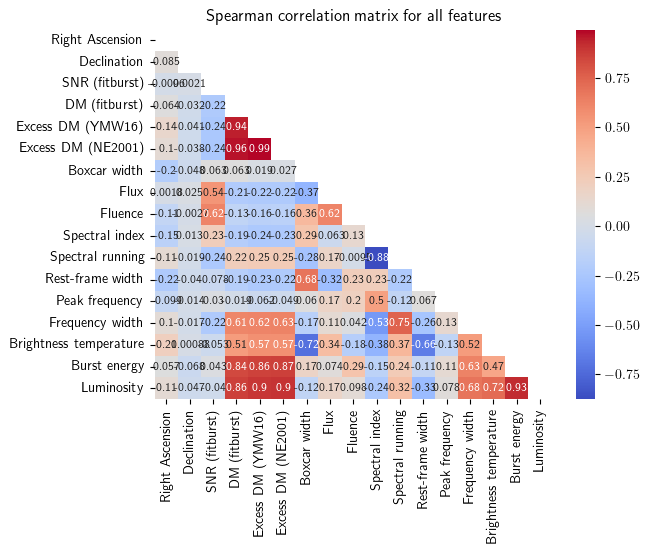

In [21]:
X = df[FEATURES]
corr_matrix = X.corr(method="spearman")
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    xticklabels=FEATURE_LABELS,
    yticklabels=FEATURE_LABELS,
    annot=True,
    annot_kws={"size": 8},
    cmap="coolwarm",
    mask=mask,
)
plt.title("Spearman correlation matrix for all features")
plt.show()